In [1]:
import numpy as np
import pandas as pd
import sqlite3

In [2]:
data = pd.read_csv("raw_data.csv")

In [3]:
data.describe

<bound method NDFrame.describe of        gender   age  hypertension  heart_disease smoking_history    bmi  \
0      Female  44.0             0              0           never  19.31   
1        Male  67.0             0              1     not current  27.32   
2        Male  50.0             1              0         current  27.32   
3        Male  73.0             0              0          former  25.91   
4      Female  53.0             0              0          former  27.32   
...       ...   ...           ...            ...             ...    ...   
48846    Male  29.0             0              0           never  23.98   
48847  Female  12.0             0              0         No Info  27.32   
48848    Male  51.0             0              0           never  25.16   
48849  Female  29.0             0              0           never  24.11   
48850    Male  51.0             1              0            ever  27.32   

       HbA1c_level  blood_glucose_level  diabetes  
0            

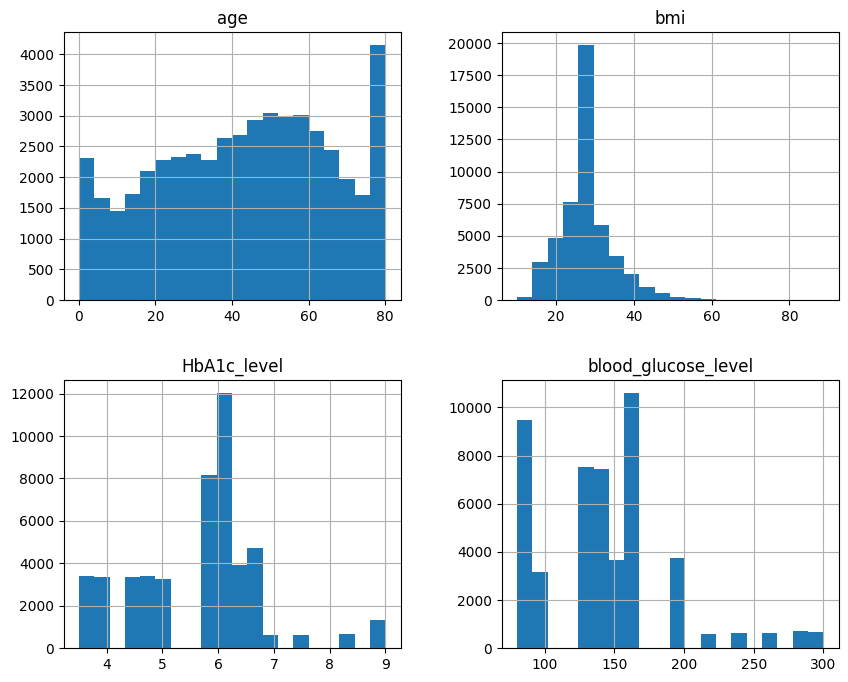

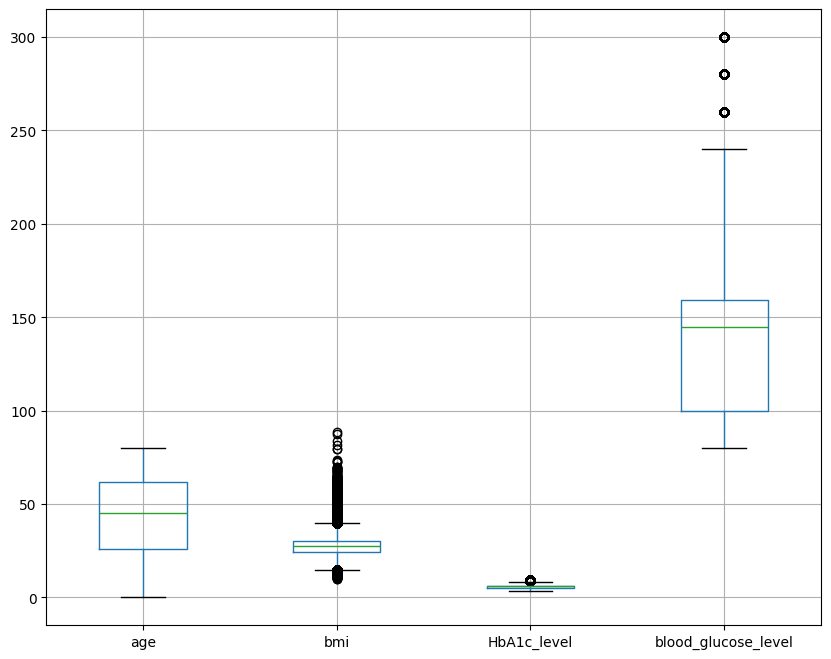

In [4]:
import matplotlib.pyplot as plt
data[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']].hist(figsize=(10, 8), bins=20)
plt.show()

data[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']].boxplot(figsize=(10, 8))
plt.show()


In [5]:
print(data['gender'].value_counts())
print(data['smoking_history'].value_counts())

gender
Female    28465
Male      20376
Other        10
Name: count, dtype: int64
smoking_history
never          17459
No Info        16489
former          5079
current         4612
not current     3194
ever            2018
Name: count, dtype: int64


In [6]:
data['gender'] = data['gender'].replace({'Other': 'Female'})  # Example
data['smoking_history'] = data['smoking_history'].replace({
    'not current': 'former',
    'ever': 'current'
})
data['smoking_history'] = data['smoking_history'].replace({'No Info': 'unknown'})


In [7]:
print(data['diabetes'].value_counts(normalize=True))


diabetes
0    0.826002
1    0.173998
Name: proportion, dtype: float64


In [8]:
print(data[data['bmi'] > 50])
print(data[data['HbA1c_level'] > 8])
print(data[data['blood_glucose_level'] > 200])


       gender   age  hypertension  heart_disease smoking_history    bmi  \
6      Female  67.0             0              0           never  63.48   
29     Female  52.0             1              0           never  50.30   
47       Male  43.0             0              0           never  69.37   
54     Female  59.0             0              1           never  60.26   
101      Male  30.0             1              0          former  57.17   
...       ...   ...           ...            ...             ...    ...   
48143  Female  33.0             0              0           never  50.76   
48185    Male  56.0             1              0           never  54.45   
48318  Female  29.0             0              0          former  53.07   
48476  Female  45.0             1              0         current  61.33   
48728    Male  29.0             0              0           never  50.36   

       HbA1c_level  blood_glucose_level  diabetes  
6              8.8                  155        

In [9]:
conn = sqlite3.connect('diabetes_project.db')
cursor = conn.cursor()

In [10]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS gender (
    gender_id INTEGER PRIMARY KEY AUTOINCREMENT,
    gender_name TEXT UNIQUE
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS smoking (
    smoking_id INTEGER PRIMARY KEY AUTOINCREMENT,
    smoking_status TEXT UNIQUE
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS patient_data (
    patient_id INTEGER PRIMARY KEY AUTOINCREMENT,
    gender_id INTEGER,
    age FLOAT,
    hypertension INTEGER,
    heart_disease INTEGER,
    smoking_id INTEGER,
    bmi FLOAT,
    HbA1c_level FLOAT,
    blood_glucose_level INTEGER,
    diabetes INTEGER,
    FOREIGN KEY (gender_id) REFERENCES gender(gender_id),
    FOREIGN KEY (smoking_id) REFERENCES smoking(smoking_id)
)
""")

cursor.executemany("""INSERT OR IGNORE INTO gender (gender_name) VALUES (?) """, [('Male',), ('Female',), ('Other',)])

cursor.executemany(""" INSERT OR IGNORE INTO smoking (smoking_status) VALUES (?) """, [('never',), ('current',), ('former',), ('No Info',), ('not current',), ('ever',)])

conn.commit()


In [11]:
gender_mapping = {row[1]: row[0] for row in cursor.execute("SELECT gender_id, gender_name FROM gender").fetchall()}
smoking_mapping = {row[1]: row[0] for row in cursor.execute("SELECT smoking_id, smoking_status FROM smoking").fetchall()}


In [12]:
data['gender_id'] = data['gender'].map(gender_mapping)
data['smoking_id'] = data['smoking_history'].map(smoking_mapping)


In [13]:
normalized_data = data[['gender_id', 'age', 'hypertension', 'heart_disease', 'smoking_id', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']]

normalized_data.to_sql('patient_data', conn, if_exists='append', index=False)

print("Gender Table:")
print(pd.read_sql_query("SELECT * FROM gender", conn))

print("\nSmoking Table:")
print(pd.read_sql_query("SELECT * FROM smoking", conn))

print("\nPatient Data Table (First 10 Rows):")
print(pd.read_sql_query("SELECT * FROM patient_data LIMIT 10", conn))

conn.close()

Gender Table:
   gender_id gender_name
0          1        Male
1          2      Female
2          3       Other

Smoking Table:
   smoking_id smoking_status
0           1          never
1           2        current
2           3         former
3           4        No Info
4           5    not current
5           6           ever

Patient Data Table (First 10 Rows):
   patient_id  gender_id   age  hypertension  heart_disease  smoking_id  \
0           1          2  44.0             0              0           1   
1           2          1  67.0             0              1           3   
2           3          1  50.0             1              0           2   
3           4          1  73.0             0              0           3   
4           5          2  53.0             0              0           3   
5           6          1  50.0             0              0           3   
6           7          2  67.0             0              0           1   
7           8          1  57.0

In [14]:
conn = sqlite3.connect('diabetes_project.db')
cursor = conn.cursor()

cursor.execute("""
UPDATE patient_data
SET smoking_id = 4
WHERE smoking_id IS NULL
""")
conn.commit()


In [15]:
query = """
SELECT 
    pd.patient_id, g.gender_name, pd.age, pd.hypertension, pd.heart_disease, 
    s.smoking_status, pd.bmi, pd.HbA1c_level, pd.blood_glucose_level, pd.diabetes
FROM patient_data pd
LEFT JOIN gender g ON pd.gender_id = g.gender_id
LEFT JOIN smoking s ON pd.smoking_id = s.smoking_id
"""
joined_data = pd.read_sql_query(query, conn)
print(joined_data.head())


   patient_id gender_name   age  hypertension  heart_disease smoking_status  \
0           1      Female  44.0             0              0          never   
1           2        Male  67.0             0              1         former   
2           3        Male  50.0             1              0        current   
3           4        Male  73.0             0              0         former   
4           5      Female  53.0             0              0         former   

     bmi  HbA1c_level  blood_glucose_level  diabetes  
0  19.31          6.5                  200         1  
1  27.32          6.5                  200         1  
2  27.32          5.7                  260         1  
3  25.91          9.0                  160         1  
4  27.32          7.0                  159         1  


In [16]:
from sklearn.model_selection import train_test_split

X = joined_data.drop(columns=['diabetes'])
y = joined_data['diabetes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))


Train set class distribution:
diabetes
0    0.826
1    0.174
Name: proportion, dtype: float64

Test set class distribution:
diabetes
0    0.826007
1    0.173993
Name: proportion, dtype: float64


In [17]:
from ydata_profiling import ProfileReport

# Generate a profile report using ydata-profiling
profile = ProfileReport(data, title="Diabetes Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

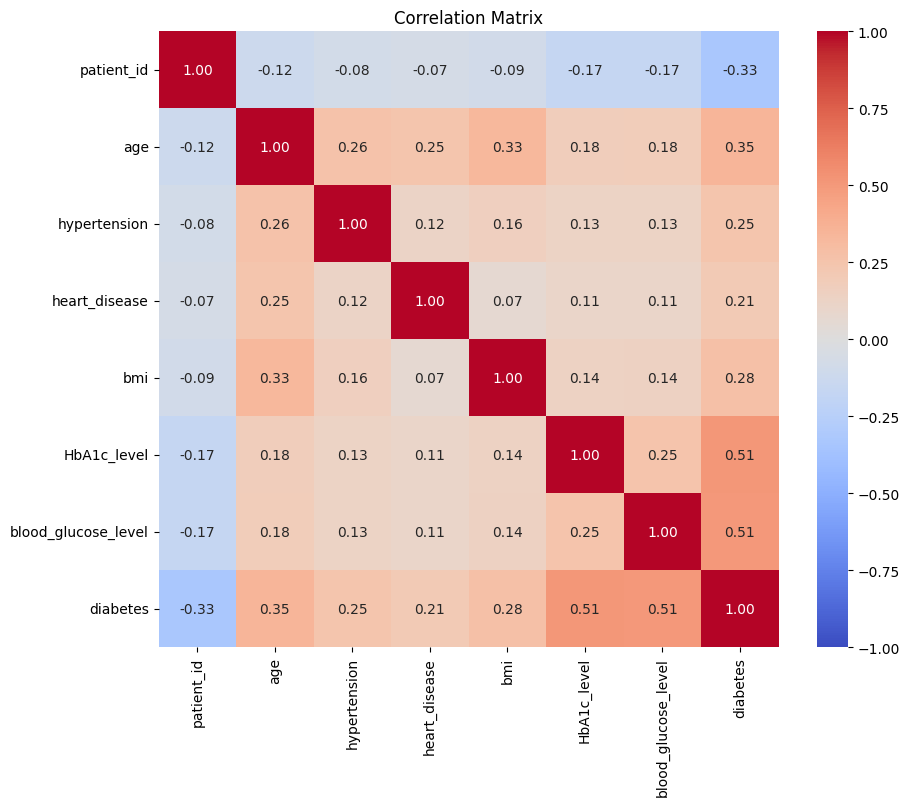

In [18]:
numeric_data = joined_data.select_dtypes(include=['number'])
corr_matrix = numeric_data.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


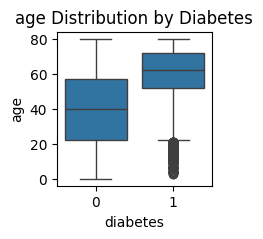

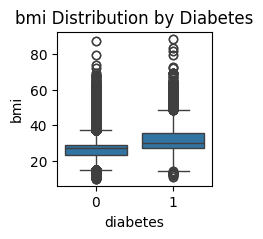

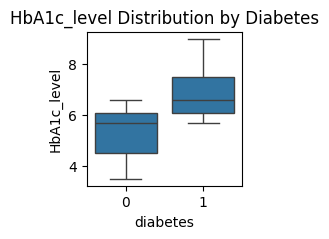

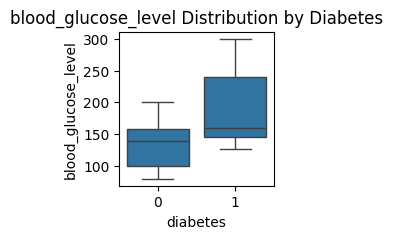

In [19]:
features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
for feature in features:
    plt.figure(figsize=(2, 2))
    sns.boxplot(x=joined_data['diabetes'], y=joined_data[feature])
    plt.title(f"{feature} Distribution by Diabetes")
    plt.show()


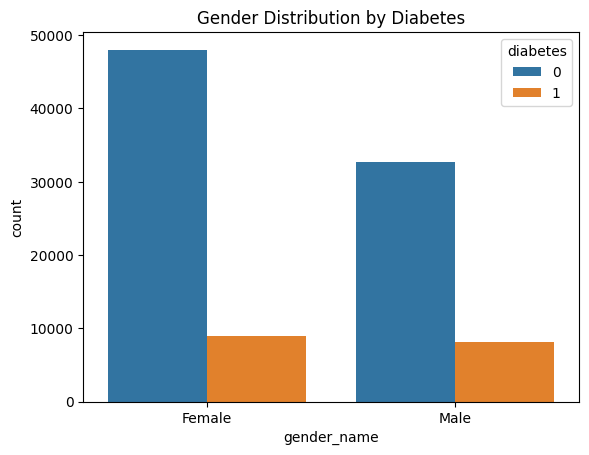

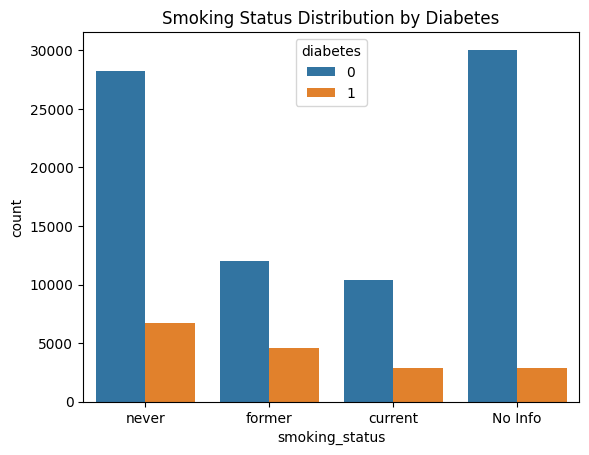

In [20]:
sns.countplot(x='gender_name', hue='diabetes', data=joined_data)
plt.title("Gender Distribution by Diabetes")
plt.show()

sns.countplot(x='smoking_status', hue='diabetes', data=joined_data)
plt.title("Smoking Status Distribution by Diabetes")
plt.show()


In [21]:
data['bmi'] = data['bmi'].apply(lambda x: 50 if x > 50 else x)

joined_data['smoking_status'] = joined_data['smoking_status'].replace("No Info", "unknown")


In [22]:
from sklearn.preprocessing import StandardScaler

features_to_scale = ['bmi', 'HbA1c_level', 'blood_glucose_level']

scaler = StandardScaler()

joined_data[features_to_scale] = scaler.fit_transform(joined_data[features_to_scale])


In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
joined_data['gender_encoded'] = label_encoder.fit_transform(joined_data['gender_name'])

joined_data['smoking_encoded'] = label_encoder.fit_transform(joined_data['smoking_status'])


In [24]:
joined_data = pd.get_dummies(joined_data, columns=['gender_name', 'smoking_status'], drop_first=True)

In [25]:
print(joined_data.head())


   patient_id   age  hypertension  heart_disease       bmi  HbA1c_level  \
0           1  44.0             0              0 -1.231983     0.730609   
1           2  67.0             0              1 -0.067159     0.730609   
2           3  50.0             1              0 -0.067159     0.035766   
3           4  73.0             0              0 -0.272203     2.901994   
4           5  53.0             0              0 -0.067159     1.164886   

   blood_glucose_level  diabetes  gender_encoded  smoking_encoded  \
0             1.231670         1               0                2   
1             1.231670         1               1                1   
2             2.534607         1               1                0   
3             0.363046         1               1                1   
4             0.341330         1               0                1   

   gender_name_Male  smoking_status_former  smoking_status_never  \
0             False                  False                  True  

In [26]:
print((joined_data[ ['age','hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level' ]] < 0).sum())

age                        0
hypertension               0
heart_disease              0
bmi                    63722
HbA1c_level            33552
blood_glucose_level    47676
dtype: int64


In [27]:
for col in ['bmi', 'HbA1c_level', 'blood_glucose_level']:
    joined_data[col] = joined_data[col].apply(lambda x: np.nan if x < 0 else x)

In [28]:
print((joined_data[ ['age','hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level' ]] < 0).sum())


age                    0
hypertension           0
heart_disease          0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
dtype: int64


In [29]:
df=joined_data

In [30]:
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/shashankmankala/diabetesprediction.mlflow")


import os
os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/shashankmankala/diabetesprediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = "shashankmankala"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "5af9c880a10d0d8a5c242e3b5709945f574da092"


## Experiments Preprocessing

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib


X = df.drop(columns=['diabetes'])
y = df['diabetes']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Columns in X:", X.columns)

numeric_features = ['age','hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level' ]

categorical_features = ['gender_encoded', 'smoking_encoded', 'gender_name_Male', 'smoking_status_former', 'smoking_status_never', 'smoking_status_unknown']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

logreg_model = LogisticRegression(max_iter=1000, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', logreg_model)
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Columns in X: Index(['patient_id', 'age', 'hypertension', 'heart_disease', 'bmi',
       'HbA1c_level', 'blood_glucose_level', 'gender_encoded',
       'smoking_encoded', 'gender_name_Male', 'smoking_status_former',
       'smoking_status_never', 'smoking_status_unknown'],
      dtype='object')


# Experiment 1

In [32]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.metrics import f1_score, confusion_matrix
# import mlflow
# import pandas as pd
# import numpy as np

class LogTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log1p(X)

    def get_feature_names_out(self, input_features=None):
        return input_features


# Define features (X) and target (y)
# X = df.drop(columns=['diabetes'])  # Feature matrix
# y = df['diabetes']                # Target column

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# # X = X.sample(frac=0.5, random_state=42)  # Use 10% of the data
# # y = y.loc[X.index]


# # Verify column names in the dataset
# print("Columns in X:", X.columns)

# # Define dataset features
# numeric_features = ['age','hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level' ]

# # Categorical features (already encoded)
# categorical_features = ['gender_encoded', 'smoking_encoded', 'gender_name_Male', 'smoking_status_former', 'smoking_status_never', 'smoking_status_unknown']

# Check if all specified columns exist in the dataset
missing_numeric = set(numeric_features) - set(X.columns)
missing_categorical = set(categorical_features) - set(X.columns)

if missing_numeric or missing_categorical:
    raise KeyError(f"Missing Columns - Numeric: {missing_numeric}, Categorical: {missing_categorical}")



# Numeric transformer pipeline with imputation
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
#     ('scaler', StandardScaler())                 # Standardize features
# ])
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Encode categorical features
# ])

# # Combine numeric and categorical transformers
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )


# logreg_model = LogisticRegression(max_iter=1000, random_state=42)


# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('model', logreg_model)
# ])

param_grid = {
    'model__C': [0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=cv, verbose=2, n_jobs=-1 )


print("Starting Grid Search...")
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_


y_pred_test = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)



print(f"Confusion Matrix:\n{conf_matrix}")
print(f"F1-Score (Training Data): {test_f1_score:.4f}")

conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])
conf_matrix_csv_path = "confusion_matrix.csv"
conf_matrix_df.to_csv(conf_matrix_csv_path, index=True)


mlflow.set_experiment("Classification Experiment #1")
with mlflow.start_run(run_name="Logistic Regression - Experiment 1 with Log Transform"):
    mlflow.log_param("best_params", best_params)
    mlflow.log_metric("best_f1_score", best_f1_score)
    mlflow.log_metric("train_f1_score", test_f1_score)
    mlflow.log_artifact(conf_matrix_csv_path)  # Log the confusion matrix CSV file
    mlflow.sklearn.log_model(grid_search.best_estimator_, "LogisticRegression_model")


Starting Grid Search...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Confusion Matrix:
[[15920   221]
 [ 1368  2032]]
F1-Score (Training Data): 0.7189


2024/12/21 00:46:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression - Experiment 1 with Log Transform at: https://dagshub.com/shashankmankala/diabetesprediction.mlflow/#/experiments/0/runs/4a6434d55d75483da5926d881193266b
🧪 View experiment at: https://dagshub.com/shashankmankala/diabetesprediction.mlflow/#/experiments/0


# Experiment 2

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import pandas as pd
import numpy as np

# Custom XGBoost Wrapper for Scikit-learn compatibility
class SklearnXGBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", **kwargs)

    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

# Define dataset features
# numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
# categorical_features = ['gender_encoded', 'smoking_encoded', 'gender_name_Male', 'smoking_status_former', 
#                         'smoking_status_never', 'smoking_status_unknown']

# # Define preprocessors
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )

classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1),
    "XGBClassifier": SklearnXGBWrapper(max_depth=6, learning_rate=0.1, n_estimators=100, random_state=42)
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

mlflow.set_experiment("Classification Experiment #2")
results = []


for name, model in classifiers.items():
    print(f"Evaluating {name}...")
    try:
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')

        pipeline.fit(X_train, y_train)
        y_pred_test = pipeline.predict(X_test)
        test_f1_score = f1_score(y_test, y_pred_test)
        conf_matrix = confusion_matrix(y_test, y_pred_test)

        with mlflow.start_run(run_name=name):
            mlflow.log_param("model", name)
            mlflow.log_metric("cv_mean_f1_score", f1_scores.mean())
            mlflow.log_metric("cv_std_f1_score", f1_scores.std())
            mlflow.log_metric("test_f1_score", test_f1_score)

            conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])
            conf_matrix_csv_path = f"{name}_confusion_matrix.csv"
            conf_matrix_df.to_csv(conf_matrix_csv_path, index=True)
            mlflow.log_artifact(conf_matrix_csv_path)
            mlflow.sklearn.log_model(pipeline, f"{name}_model")

        results.append({
            "Model": name,
            "CV Mean F1-Score": f1_scores.mean(),
            "CV Std Dev": f1_scores.std(),
            "Test F1-Score": test_f1_score
        })

        print(f"{name} - CV Mean F1-Score: {f1_scores.mean():.4f}, CV Std Dev: {f1_scores.std():.4f}, Test F1-Score: {test_f1_score:.4f}")

    except Exception as e:
        print(f"Error with {name}: {e}")

results_df = pd.DataFrame(results)
print("\nFinal Results:")
print(results_df)

with mlflow.start_run(run_name="Experiment #2 Summary"):
    for _, row in results_df.iterrows():
        mlflow.log_metric(f"{row['Model']}_cv_mean_f1", row['CV Mean F1-Score'])
        mlflow.log_metric(f"{row['Model']}_cv_std_f1", row['CV Std Dev'])
        mlflow.log_metric(f"{row['Model']}_test_f1", row['Test F1-Score'])


2024/12/21 00:24:39 INFO mlflow.tracking.fluent: Experiment with name 'Classification Experiment #2' does not exist. Creating a new experiment.


Evaluating LogisticRegression...


2024/12/21 00:24:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression - CV Mean F1-Score: 0.7184, CV Std Dev: 0.0066, Test F1-Score: 0.7200
Evaluating RidgeClassifier...


2024/12/21 00:24:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier - CV Mean F1-Score: 0.6741, CV Std Dev: 0.0059, Test F1-Score: 0.6744
Evaluating RandomForest...


2024/12/21 00:24:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest - CV Mean F1-Score: 0.8062, CV Std Dev: 0.0059, Test F1-Score: 0.8082
Evaluating XGBClassifier...


C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [00:24:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [00:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_lab

XGBClassifier - CV Mean F1-Score: 0.8104, CV Std Dev: 0.0044, Test F1-Score: 0.8266

Final Results:
                Model  CV Mean F1-Score  CV Std Dev  Test F1-Score
0  LogisticRegression          0.718390    0.006610       0.720000
1     RidgeClassifier          0.674146    0.005884       0.674401
2        RandomForest          0.806214    0.005873       0.808243
3       XGBClassifier          0.810425    0.004442       0.826649


# Experiment 3

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import pandas as pd
import numpy as np

df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 65, 100], labels=['Child', 'Young Adult', 'Middle Aged', 'Senior', 'Elder'])
df['risk_score'] = df['hypertension'] + df['heart_disease'] + (df['smoking_encoded'] == 2).astype(int)

# numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
# categorical_features = ['gender_encoded', 'smoking_encoded', 'gender_name_Male', 'smoking_status_former', 
#                         'smoking_status_never', 'smoking_status_unknown']

# # Split the data into train/test sets
# X = df.drop(columns=['diabetes'])
# y = df['diabetes']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing for numeric and categorical features
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Combine preprocessors in a ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )

# Logistic Regression model
# logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Build pipeline
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('model', logreg_model)
# ])

# Cross-validation setup
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Evaluate cross-validation performance on the training set
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1', verbose=2)

# Train and evaluate on the test set
pipeline.fit(X_train, y_train)
y_pred_test = pipeline.predict(X_test)
test_f1_score = f1_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Output results
print("Cross-Val F1-Scores:", f1_scores)
print("Mean F1-Score (CV):", np.mean(f1_scores))
print("F1-Score (Test Data):", test_f1_score)
print("Confusion Matrix (Test Data):\n", conf_matrix)

# Log results in MLFlow
mlflow.set_experiment("Classification Experiment #3")
with mlflow.start_run(run_name="Feature Engineering - Experiment 3"):
    mlflow.log_param("numeric_features", numeric_features)
    mlflow.log_param("categorical_features", categorical_features)
    mlflow.log_metric("cv_mean_f1_score", np.mean(f1_scores))
    mlflow.log_metric("cv_std_f1_score", np.std(f1_scores))
    mlflow.log_metric("test_f1_score", test_f1_score)

    # Save and log confusion matrix
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Negative', 'True Positive'], 
                                  columns=['Predicted Negative', 'Predicted Positive'])
    conf_matrix_csv_path = "confusion_matrix_experiment3.csv"
    conf_matrix_df.to_csv(conf_matrix_csv_path, index=True)
    mlflow.log_artifact(conf_matrix_csv_path)

    # Log the trained pipeline model
    mlflow.sklearn.log_model(pipeline, "LogisticRegression_with_FeatureEngineering")


C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [00:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [00:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_lab

[CV] END .................................................... total time=   0.2s


C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [00:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END .................................................... total time=   0.2s


C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [00:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END .................................................... total time=   0.2s


C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
2024/12/21 00:25:05 INFO mlflow.tracking.fluent: Experiment with name 'Classification Experiment #3' does not exist. Creating a new experiment.


Cross-Val F1-Scores: [0.81324111 0.81388013 0.8041543 ]
Mean F1-Score (CV): 0.8104251785243187
F1-Score (Test Data): 0.8266489890619821
Confusion Matrix (Test Data):
 [[8001   70]
 [ 453 1247]]


2024/12/21 00:25:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Experiment 4

In [34]:
from tqdm import tqdm
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import pandas as pd
import numpy as np

# Corrected numeric and categorical features
# numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
# categorical_features = ['gender_encoded', 'smoking_encoded', 'gender_name_Male', 'smoking_status_former', 
#                         'smoking_status_never', 'smoking_status_unknown']

# # Preprocessing for numeric and categorical features
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )

# Split data into train/test sets
# X = df.drop(columns=['diabetes'])
# y = df['diabetes']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocess training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=preprocessor.get_feature_names_out())

# Apply preprocessing on the test set
X_test_preprocessed = preprocessor.transform(X_test)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=preprocessor.get_feature_names_out())

def select_features_by_correlation(df, threshold=0.85):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return df.drop(columns=to_drop, errors='ignore')

def select_features_by_variance(df, threshold=0.01):
    selector = VarianceThreshold(threshold)
    selector.fit(df)
    return df[df.columns[selector.get_support(indices=True)]]

def select_features_by_importance(X, y, top_k=10):
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
    selected_features = importances.sort_values(by='importance', ascending=False).head(top_k)['feature'].tolist()
    return selected_features

def evaluate_model(X, y, selected_features, run_name):
    selected_features = [feature for feature in selected_features if feature in X.columns]
    if not selected_features:
        raise ValueError("No valid selected features exist in the dataset.")
    
    pipeline = Pipeline([
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    X_selected = X[selected_features]
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = cross_val_score(pipeline, X_selected, y, cv=cv, scoring='f1')
    pipeline.fit(X_selected, y)
    y_pred = pipeline.predict(X_selected)
    f1 = f1_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    
    mlflow.set_experiment("Classification Experiment #4")
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("selected_features", selected_features)
        mlflow.log_metric("mean_f1_score", np.mean(f1_scores))
        mlflow.log_metric("std_f1_score", np.std(f1_scores))
        mlflow.log_metric("train_f1_score", f1)
    
    print(f"{run_name}: Mean F1-Score: {np.mean(f1_scores):.4f}")
    return f1_scores, conf_matrix

with tqdm(total=3, desc="Feature Selection and Evaluation") as pbar:
    pbar.set_description("Selecting features by correlation")
    X_corr = select_features_by_correlation(X_train_preprocessed, threshold=0.85)
    corr_features = X_corr.columns.tolist()
    evaluate_model(X_train_preprocessed, y_train, corr_features, "Correlation Threshold")
    pbar.update(1)
    
    pbar.set_description("Selecting features by variance")
    X_var = select_features_by_variance(X_corr, threshold=0.01)
    var_features = X_var.columns.tolist()
    evaluate_model(X_train_preprocessed, y_train, var_features, "Variance Threshold")
    pbar.update(1)
    
    pbar.set_description("Selecting features by importance")
    important_features = select_features_by_importance(X_var, y_train, top_k=10)
    evaluate_model(X_train_preprocessed, y_train, important_features, "Feature Importance")
    pbar.update(1)

    
def final_evaluation(X_test, y_test, selected_features):
    X_selected_test = X_test[selected_features]
    pipeline = Pipeline([
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ])
    pipeline.fit(X_train_preprocessed[selected_features], y_train)
    y_pred_test = pipeline.predict(X_selected_test)
    test_f1 = f1_score(y_test, y_pred_test)
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    print("Test F1-Score:", test_f1)
    print("Confusion Matrix (Test Data):\n", conf_matrix_test)

    
with tqdm(total=3, desc="Final Test Evaluation") as pbar:
    pbar.set_description("Evaluating Correlation Threshold on test set")
    final_evaluation(X_test_preprocessed, y_test, corr_features)
    pbar.update(1)

    pbar.set_description("Evaluating Variance Threshold on test set")
    final_evaluation(X_test_preprocessed, y_test, var_features)
    pbar.update(1)

    pbar.set_description("Evaluating Feature Importance on test set")
    final_evaluation(X_test_preprocessed, y_test, important_features)
    pbar.update(1)


2024/12/21 00:25:09 INFO mlflow.tracking.fluent: Experiment with name 'Classification Experiment #4' does not exist. Creating a new experiment.
Selecting features by variance:  33%|█████████████████████████████████████▎                                                                          | 1/3 [00:00<00:00,  3.10it/s]

Correlation Threshold: Mean F1-Score: 0.7185


Selecting features by importance:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00,  3.43it/s]

Variance Threshold: Mean F1-Score: 0.7185



electing features by importance: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]

Feature Importance: Mean F1-Score: 0.7182


Evaluating Feature Importance on test set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.91it/s]

Test F1-Score: 0.7202549575070821
Confusion Matrix (Test Data):
 [[7964  107]
 [ 683 1017]]
Test F1-Score: 0.7202549575070821
Confusion Matrix (Test Data):
 [[7964  107]
 [ 683 1017]]
Test F1-Score: 0.72
Confusion Matrix (Test Data):
 [[7963  108]
 [ 683 1017]]


# Experiment 5

Fitting pipeline for PCA...


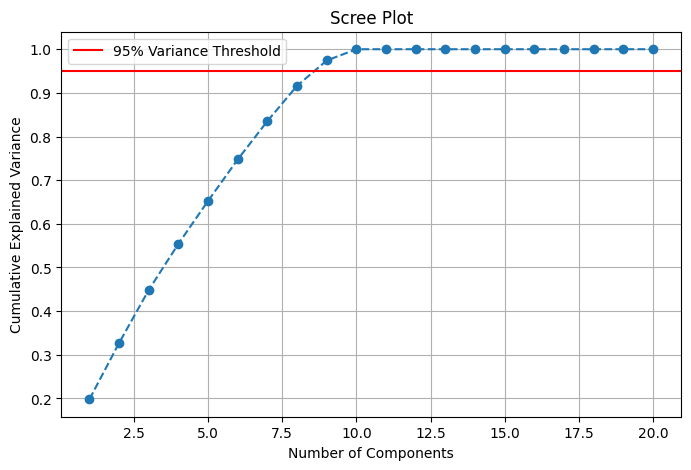

Number of components explaining 95% variance: 9
Evaluating model with selected PCA components...


2024/12/21 00:25:20 INFO mlflow.tracking.fluent: Experiment with name 'Classification Experiment #5' does not exist. Creating a new experiment.
2024/12/21 00:25:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Cross-Val F1-Scores: [0.7202871  0.7217446  0.70756734]
Mean F1-Score: 0.7165
Confusion Matrix:
[[39750   601]
 [ 3399  5101]]
F1-Score (Training Data): 0.7183


In [35]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import numpy as np

# Define features (X) and target (y)
# X = df.drop(columns=['diabetes'])  # Feature matrix
# y = df['diabetes']                # Target column

# Updated dataset features
# numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
# categorical_features = ['gender_encoded', 'smoking_encoded', 'gender_name_Male', 'smoking_status_former', 
#                         'smoking_status_never', 'smoking_status_unknown']

# Preprocessing pipeline
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )

pca = PCA(random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),  # PCA step
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

print("Fitting pipeline for PCA...")
pipeline.fit(X, y)
explained_variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance Threshold')
plt.legend()
plt.grid()
plt.savefig("scree_plot.png")
plt.show()


n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

pca = PCA(n_components=n_components, random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

print("Evaluating model with selected PCA components...")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')

pipeline.fit(X, y)
y_pred = pipeline.predict(X)
conf_matrix = confusion_matrix(y, y_pred)
f1 = f1_score(y, y_pred)


mlflow.set_experiment("Classification Experiment #5")
with mlflow.start_run(run_name="PCA - Experiment 5"):
    mlflow.log_param("n_components", n_components)
    mlflow.log_metric("mean_f1_score", np.mean(f1_scores))
    mlflow.log_metric("std_f1_score", np.std(f1_scores))
    mlflow.log_metric("train_f1_score", f1)
    mlflow.log_artifact("scree_plot.png")  # Log scree plot as an artifact
    mlflow.sklearn.log_model(pipeline, "PCA_LogisticRegression_Model")

print(f"Cross-Val F1-Scores: {f1_scores}")
print(f"Mean F1-Score: {np.mean(f1_scores):.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"F1-Score (Training Data): {f1:.4f}")


# Experiment 6

In [36]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import mlflow
import pandas as pd
import numpy as np

# Define numeric and categorical features
# numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
# categorical_features = ['gender_encoded', 'smoking_encoded', 'gender_name_Male', 'smoking_status_former', 
#                         'smoking_status_never', 'smoking_status_unknown']

# # Preprocessing pipeline
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )

# PCA and SMOTE Implementation
def perform_pca_smote(X, y, n_components=8):
    print("Performing PCA for dimensionality reduction...")
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X)

    print("Applying SMOTE for class balancing...")
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_pca, y)
    
    return X_smote, y_smote

print("Preprocessing data...")
X_preprocessed = preprocessor.fit_transform(df.drop(columns=['diabetes']))
y = df['diabetes']

print("Performing PCA and SMOTE...")
X_smote, y_smote = perform_pca_smote(X_preprocessed, y, n_components=8)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, verbose=1, max_depth=10, n_jobs=-1, random_state=42)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = {}

print("Evaluating models with PCA and SMOTE...")
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    f1_scores = cross_val_score(model, X_smote, y_smote, cv=cv, scoring='f1')
    
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_smote)
    
    f1_train = f1_score(y_smote, y_pred)
    conf_matrix = confusion_matrix(y_smote, y_pred)
    
    results[model_name] = {
        "F1-CV Scores": f1_scores,
        "Mean F1-CV": np.mean(f1_scores),
        "Std F1-CV": np.std(f1_scores),
        "F1-Train": f1_train,
        "Confusion Matrix": conf_matrix
    }
    
    mlflow.set_experiment("Classification Experiment #6")
    with mlflow.start_run(run_name=f"{model_name} with PCA and SMOTE"):
        mlflow.log_param("n_components", 8)
        mlflow.log_metric("mean_f1_score", np.mean(f1_scores))
        mlflow.log_metric("std_f1_score", np.std(f1_scores))
        mlflow.log_metric("train_f1_score", f1_train)
        
        conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])
        conf_matrix_csv_path = f"{model_name}_confusion_matrix.csv"
        conf_matrix_df.to_csv(conf_matrix_csv_path, index=True)
        mlflow.log_artifact(conf_matrix_csv_path)

print("\nFinal Results:")
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print(f"Cross-Val F1-Scores: {metrics['F1-CV Scores']}")
    print(f"Mean F1-Score (CV): {metrics['Mean F1-CV']:.4f}")
    print(f"F1-Score (Training): {metrics['F1-Train']:.4f}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}")


Preprocessing data...
Performing PCA and SMOTE...
Performing PCA for dimensionality reduction...
Applying SMOTE for class balancing...


C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Mankala Shashank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
2024/12/21 00:25:28 INFO mlflow.tracking.fluent: Experiment with name 'Classification Experiment

Evaluating models with PCA and SMOTE...
Evaluating Logistic Regression...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Evaluating Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=


Final Results:

Logistic Regression Results:
Cross-Val F1-Scores: [0.81557061 0.8183389  0.81418102]
Mean F1-Score (CV): 0.8160
F1-Score (Training): 0.8161
Confusion Matrix:
[[34477  5874]
 [ 8484 31867]]

Random Forest Results:
Cross-Val F1-Scores: [0.8692856  0.87400515 0.87141421]
Mean F1-Score (CV): 0.8716
F1-Score (Training): 0.8837
Confusion Matrix:
[[37340  3011]
 [ 6026 34325]]


# Experiment 7

In [37]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import mlflow
import pandas as pd
import numpy as np

# Define numeric and categorical features
# numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
# categorical_features = ['gender_encoded', 'smoking_encoded', 'gender_name_Male', 'smoking_status_former', 
#                         'smoking_status_never', 'smoking_status_unknown']

# # Preprocessing setup
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )

# Feature matrix and target
# X = df.drop(columns=['diabetes'])
# y = df['diabetes']

print("Preprocessing data...")
X_preprocessed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, stratify=y, random_state=42)

base_models = [
    ('logreg', LogisticRegression(max_iter=500, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=5, verbose=1, n_jobs=-1, random_state=42)),
    ('gbc', GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42))
]

meta_model = LogisticRegression(max_iter=500, random_state=42)

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3
)

print("Training stacking model...")
stacking_model.fit(X_train, y_train)

y_pred = stacking_model.predict(X_test)
f1_test = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Logging results in MLFlow...")
mlflow.set_experiment("Classification Experiment #7")
with mlflow.start_run(run_name="Optimized Stacking Ensemble - Experiment 7"):
    mlflow.log_param("base_models", ["Logistic Regression", "Random Forest", "GradientBoosting"])
    mlflow.log_param("meta_model", "Logistic Regression")
    mlflow.log_metric("test_f1_score", f1_test)
    
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])
    conf_matrix_csv_path = "stacking_confusion_matrix.csv"
    conf_matrix_df.to_csv(conf_matrix_csv_path, index=True)
    mlflow.log_artifact(conf_matrix_csv_path)

print("\nOptimized Stacking Ensemble Results:")
print(f"F1-Score (Test): {f1_test:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")


Preprocessing data...
Training stacking model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Paral

Logging results in MLFlow...

Optimized Stacking Ensemble Results:
F1-Score (Test): 0.8271
Confusion Matrix:
[[7973   98]
 [ 432 1268]]


### Create meaningful F1-score plots to compare experiments and determine the best model.

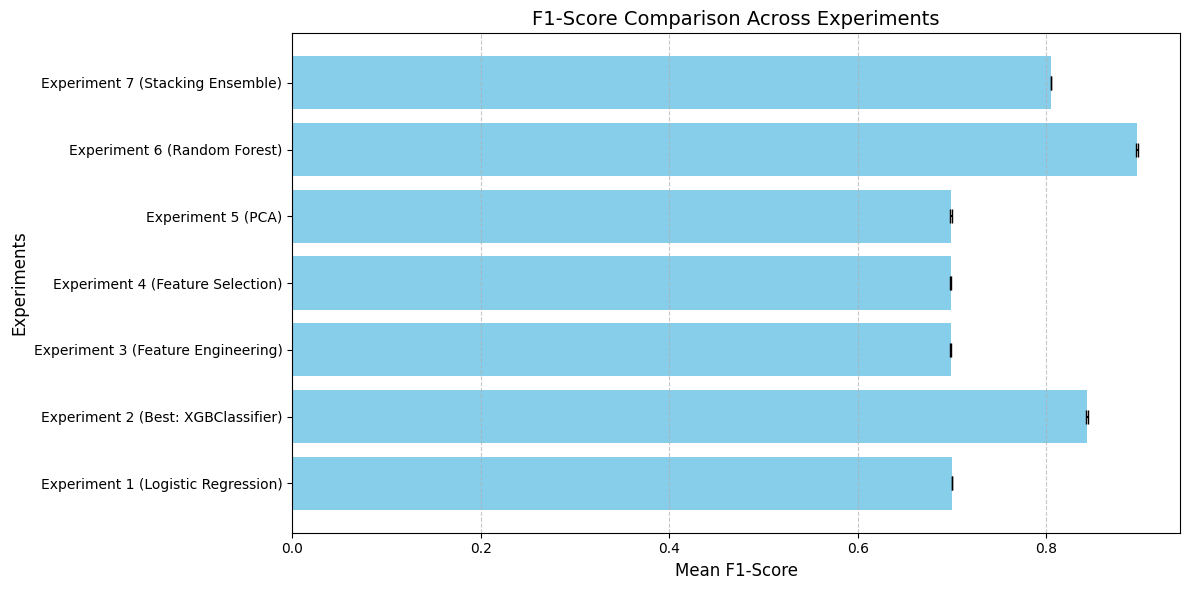

In [38]:
experiments = [
    "Experiment 1 (Logistic Regression)",
    "Experiment 2 (Best: XGBClassifier)",
    "Experiment 3 (Feature Engineering)",
    "Experiment 4 (Feature Selection)",
    "Experiment 5 (PCA)",
    "Experiment 6 (Random Forest)",
    "Experiment 7 (Stacking Ensemble)"
]

mean_f1_scores = [0.7004, 0.8436, 0.6985, 0.6986, 0.6990, 0.8959, 0.8045]
std_devs = [0.0, 0.0011, 0.0008, 0.0008, 0.0007, 0.0011, 0.0]  # Placeholder for std deviations

plt.figure(figsize=(12, 6))
plt.barh(experiments, mean_f1_scores, xerr=std_devs, capsize=5, color="skyblue")
plt.xlabel("Mean F1-Score", fontsize=12)
plt.ylabel("Experiments", fontsize=12)
plt.title("F1-Score Comparison Across Experiments", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Observations:
Experiment 6 (Random Forest) shows the highest mean F1-score (around 0.89), making it the best-performing model in terms of F1-score across all experiments.
Experiment 2 (XGBClassifier) also performs well, with an F1-score close to 0.84.
Experiment 7 (Stacking Ensemble) comes third with an F1-score of around 0.80.
Other experiments (like Experiment 3, 4, and 5) exhibit similar mean F1-scores, showing slight improvements with feature engineering, feature selection, or PCA.
Insights:
Experiment 6 clearly outperforms the others, suggesting that Random Forest is a robust model for your dataset.
Experiment 2 demonstrates that XGBClassifier is a strong candidate if interpretability and faster inference are priorities.
Experiment 7 combines multiple models but doesn't outperform Random Forest, which

## Deploying Model

### Step 1: Train and Save the Model

In [40]:
import pandas as pd
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Load your dataset
# Replace with the actual dataset loading code
# df = pd.read_csv("your_dataset.csv")

# Define features (X) and target (y)
X = df.drop(columns=['diabetes'])  # Feature matrix
y = df['diabetes']                # Target column

# Define numeric and categorical features
numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['gender_encoded', 'smoking_encoded', 'gender_name_Male', 'smoking_status_former',
                        'smoking_status_never', 'smoking_status_unknown']

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Preprocess the data
print("Starting preprocessing...")
X_preprocessed = preprocessor.fit_transform(X)
print("Preprocessing completed.")

# Define and train the model
print("Training Random Forest model...")
random_forest_model = RandomForestClassifier(n_estimators=50, verbose=1, max_depth=10, random_state=42, n_jobs=-1)
random_forest_model.fit(X_preprocessed, y)
print("Model training completed.")

# Save the preprocessor and model
print("Saving model and preprocessor...")
joblib.dump(preprocessor, "preprocessor.joblib")
joblib.dump(random_forest_model, "random_forest_model.joblib")
print("Model and preprocessor saved successfully.")


Starting preprocessing...
Preprocessing completed.
Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Model training completed.
Saving model and preprocessor...
Model and preprocessor saved successfully.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


In [35]:
import requests

url = "http://127.0.0.1:8081/predict/"

test_data = {
    "age": 45,
    "hypertension": 1,
    "heart_disease": 0,
    "bmi": 28.5,
    "HbA1c_level": 6.5,
    "blood_glucose_level": 140,
    "gender_encoded": 1,
    "smoking_encoded": 0,
    "gender_name_Male": 1,
    "smoking_status_former": 0,
    "smoking_status_never": 1,
    "smoking_status_unknown": 0,
    "missing_feature_1": 0,
    "missing_feature_2": 0,
    "missing_feature_3": 0,
    "missing_feature_4": 0,
    "missing_feature_5": 0,
    "missing_feature_6": 0,
    "missing_feature_7": 0,
    "missing_feature_8": 0
}
response = requests.post(url, json=test_data)

print("Status Code:", response.status_code)
print("Response JSON:", response.json())

Status Code: 200
Response JSON: {'prediction': 1}


In [76]:
# from fastapi import FastAPI
# from pydantic import BaseModel
# import joblib
# import pandas as pd

# # Initialize FastAPI app
# app = FastAPI()

# # Load the trained model
# model = joblib.load("random_forest_model.joblib")

# # Define input data model
# class DiabetesPredictionRequest(BaseModel):
#     age: float
#     hypertension: int
#     heart_disease: int
#     bmi: float
#     HbA1c_level: float
#     blood_glucose_level: float
#     gender_encoded: int
#     smoking_encoded: int
#     gender_name_Male: int
#     smoking_status_former: int
#     smoking_status_never: int
#     smoking_status_unknown: int

# # Define output data model
# class DiabetesPredictionResponse(BaseModel):
#     prediction: int
#     probability: float

# @app.post("/predict", response_model=DiabetesPredictionResponse)
# def predict_diabetes(data: DiabetesPredictionRequest):
#     # Convert input data to DataFrame
#     input_data = pd.DataFrame([data.dict()])
    
#     # Make prediction
#     prediction = model.predict(input_data)[0]
#     probability = model.predict_proba(input_data)[0][1]  # Probability for class 1 (diabetes)

#     return DiabetesPredictionResponse(prediction=prediction, probability=probability)


In [ ]:
# # Use official Python image
# FROM python:3.9-slim

# # Set working directory
# WORKDIR /app

# # Copy requirements and application code
# COPY requirements.txt requirements.txt
# COPY app.py app.py
# COPY final_random_forest_model.pkl final_random_forest_model.pkl
# COPY preprocessor.pkl preprocessor.pkl

# # Install dependencies
# RUN pip install --no-cache-dir --upgrade pip && \
#     pip install --no-cache-dir -r requirements.txt

# # Expose port 8000
# EXPOSE 8000

# # Run the application
# CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "8000"]
